In [ ]:
#################################################
################  Import things #################
#################################################

import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import lsmr
import jax
import jax.numpy as jnp
import jax.experimental as jexp
from jax.experimental import sparse as jexps
import networkx as nx
from math import exp
from functools import partial
import timeit
import random
import copy
import matplotlib.pyplot as plt
#import tensorflow as tf
#from tensorflow.keras.datasets import mnistß
from sklearn import datasets
import pickle
import umap

## here are the user-defined functions and classes
from MarkovComputations import WeightMatrix, InputData, get_input_inds, get_output_inds, random_initial_parameters, compute_error, downsample_avg, load_and_format_mnist, load_and_format_iris, evaluate_accuracy, evaluate_accuracy_per_class

2
5
10
20


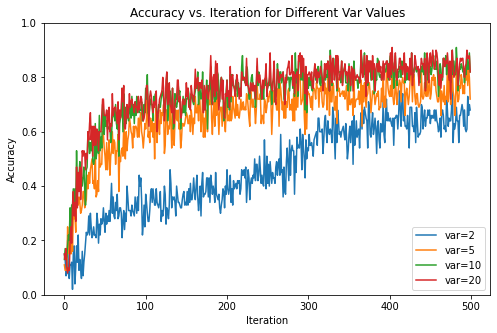

In [4]:
input_file = "/Users/csfloyd/Library/CloudStorage/Dropbox/Projects/MarkovComputation/Dirs/"
input_file = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/Dirs/M_stacked_1/"
input_file = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/Dirs/A_fac/"
input_file = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/Dirs/M_L2_full/"
input_file = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/Dirs/n_nodes_L2_full/"
input_file = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/Dirs/M_p_full_long3/"
input_file = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/Dirs/external_output_dim/"
#input_file = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/Dirs/external_output_dim_p_full_n/"
#input_file = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/Dirs/dim_L2_full/"
#input_file = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/Dirs/dims/"

var_list = [60, 70, 80, 90, 100]
var_list = [1, 10,15,20,30]
var_list = [1,2,3,4,5,10,20]
var_list = [1]
var_list = [1,2,3,4,5,6]
var_list = [6,8,10]
var_list = [5,10,15,20]
#var_list = [10,20,30, 40, 50]
var_list = [2,5,10,20,30]
#var_list = [50, 60, 70]
#var_list = [5, 25, 50, 75]
var_list = [1,2,4,6]
var_list = [10,15,20]
var_list = [2, 5, 10, 20]
#var_list = [5,10,20,30]

#var_list = []


plt.figure(figsize=(8, 5))

weight_matrices_list = []
for var in var_list:
    print(var)
    with open(input_file + str(var) + "/SavedData.pkl", 'rb') as file:
        # weight_matrix, input_data, accuracy_list, input_inds, output_inds = pickle.load(file)
        network, input_data, accuracy_list, error_list = pickle.load(file)
        weight_matrices_list.append(network)
        #print(stacked_weight_matrices.weight_matrix_list[-1].W_mat)

    plt.plot(accuracy_list, label=f"var={var}")

    
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.ylim(0,1)
#plt.xlim(0,400)
plt.title("Accuracy vs. Iteration for Different Var Values")
plt.legend()
plt.show()

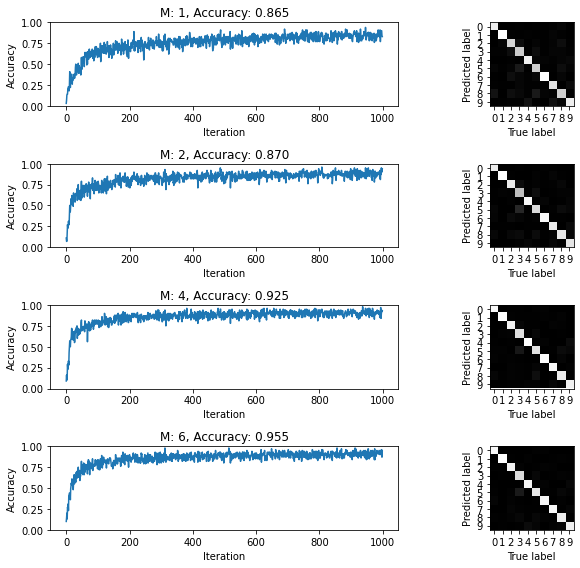

In [10]:
fig, axes = plt.subplots(len(var_list), 2, figsize=(10, 2 * len(var_list)))

n_classes = 10
n_eval = 200
for i, var in enumerate(var_list):
    with open(input_file + str(var) + "/SavedData.pkl", 'rb') as file:
        network, input_data, accuracy_list, error_list = pickle.load(file)

    res = evaluate_accuracy(network, input_data, n_classes, n_eval)
    predictions_per_class = evaluate_accuracy_per_class(network, input_data, n_eval, n_classes)

    # Plot accuracy curve
    axes[i, 0].plot(accuracy_list)
    axes[i, 0].set_title(f"M: {var}, Accuracy: {res:.3f}")
    axes[i, 0].set_xlabel("Iteration")
    axes[i, 0].set_ylabel("Accuracy")
    axes[i, 0].set_ylim(0,1)

    # Show predictions per class
    im = axes[i, 1].imshow(predictions_per_class, cmap='gray')
    axes[i, 1].set_xlabel("True label")
    axes[i, 1].set_ylabel("Predicted label")
    axes[i, 1].set_xticks(range(10))
    axes[i, 1].set_yticks(range(10))

fig.tight_layout()
plt.show()

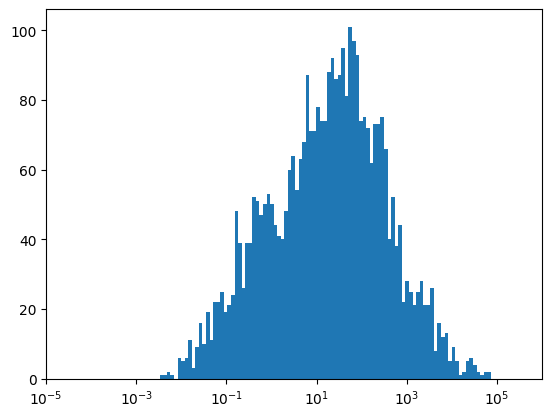

In [6]:
M = 20
with open(input_file + str(M) + "/SavedData.pkl", 'rb') as file:
        network, input_data, accuracy_list, error_list = pickle.load(file)

W_mat = network.weight_matrix_list[0].W_mat
off_diagonal_terms = [W_mat[i,j] for i in range(W_mat.shape[0]) for j in range(W_mat.shape[1]) if i != j]
# Create logarithmically spaced bins
min_val = min(off_diagonal_terms)
max_val = max(off_diagonal_terms) 
bins = np.logspace(np.log10(min_val), np.log10(max_val), 100)

plt.hist(off_diagonal_terms, bins=bins)
plt.xscale('log')
plt.xlim(1e-5, 1e6)
plt.show()

In [16]:
from itertools import islice

def compute_flux_and_frenesy_stacked(stacked_wm, inputs):
    """
    For a StackedWeightMatrices object and input vector, compute for each layer and each edge:
      - flux: J_{i->j} = pi_i * W_ij - pi_j * W_ji
      - frenesy: F_{i->j} = pi_i * W_ij + pi_j * W_ji
    Returns a list (one per layer) of tuples:
      (input_edges_results, non_input_edges_results),
    where each is a list of dicts with keys: 'edge', 'flux', 'frenesy'.
    """
    results = []
    # Get steady states for all layers
    ss_list, _ = stacked_wm.compute_stacked_ss_on_inputs(inputs)
    for l, wm in enumerate(stacked_wm.weight_matrix_list):
        pi = np.array(ss_list[l])
        edge_array = wm.edge_array
        W_mat = wm.W_mat
        # Get input edge indices for this layer
        if l == 0:
            input_edge_inds = set(idx for sublist in stacked_wm.external_input_inds for idx in sublist)
        else:
            input_edge_inds = set(idx for sublist in stacked_wm.internal_input_inds[l-1] for idx in sublist)
        input_edges_results = []
        non_input_edges_results = []
        combined_edges_results = []
        for idx, (i, j) in enumerate(edge_array):
            flux = pi[i] * W_mat[i, j] - pi[j] * W_mat[j, i]
            frenesy = pi[i] * W_mat[i, j] + pi[j] * W_mat[j, i]
            entry = {'edge': (i, j), 'flux': flux, 'frenesy': frenesy}
            if idx in input_edge_inds:
                input_edges_results.append(entry)
            else:
                non_input_edges_results.append(entry)
            combined_edges_results.append(entry)
        results.append((input_edges_results, non_input_edges_results, combined_edges_results))
    return results

def entropy(flux_matrix):
    # Take absolute values since we care about magnitude of fluxes
    abs_flux = np.abs(flux_matrix)
    
    # Get probabilities for each row by normalizing
    row_sums = np.sum(abs_flux, axis=1)
    # Add small epsilon to avoid division by zero
    row_sums = row_sums + 1e-10
    
    # Normalize each row
    probs = abs_flux / row_sums[:, np.newaxis]
    
    # Add small epsilon to avoid log(0)
    safe_probs = probs + 1e-10
    safe_probs = safe_probs / np.sum(safe_probs, axis=1)[:, np.newaxis]
    
    # Calculate entropy for each row
    return -np.sum(safe_probs * np.log(safe_probs), axis=1)

def entropy_for_digits(flux_matrix):
    # Take absolute values since we care about magnitude of fluxes
    abs_flux = np.abs(flux_matrix)
    
    # Get probabilities for each row by normalizing
    col_sums = np.sum(abs_flux, axis=0)
    # Add small epsilon to avoid division by zero
    col_sums = col_sums + 1e-10
    
    # Normalize each row
    probs = abs_flux / col_sums[np.newaxis,:]
    
    # Add small epsilon to avoid log(0)
    safe_probs = probs + 1e-10
    safe_probs = safe_probs / np.sum(safe_probs, axis=0)[np.newaxis,:]
    
    # Calculate entropy for each row
    return -np.sum(safe_probs * np.log(safe_probs), axis=0)

def entropy_for_digits(flux_matrix):
    # Take absolute values since we care about magnitude of fluxes
    abs_flux = np.abs(flux_matrix)
    
    # Get probabilities for each row by normalizing
    col_sums = np.sum(abs_flux, axis=0)
    # Add small epsilon to avoid division by zero
    col_sums = col_sums + 1e-10
    
    # Normalize each row
    probs = abs_flux / col_sums[np.newaxis,:]
    
    # Add small epsilon to avoid log(0)
    safe_probs = probs + 1e-10
    safe_probs = safe_probs / np.sum(safe_probs, axis=0)[np.newaxis,:]
    
    # Calculate entropy for each row
    return -np.sum(safe_probs * np.log(safe_probs), axis=0)

# Function to count singular values above threshold
def count_above_threshold(values, threshold):
    return np.sum(values > threshold)

M = 20
with open(input_file + str(M) + "/SavedData.pkl", 'rb') as file:
        network, input_data, accuracy_list, error_list = pickle.load(file)

class_number = 0
inputs = next(input_data.training_data[class_number])  

PP = 20
input_dict = {i: list(islice(input_data.training_data[i], PP)) for i in range(10)}

results_input_dict = {
    i: [
        [layer_result[0] for layer_result in compute_flux_and_frenesy_stacked(network, input_dict[i][m])]
        for m in range(PP)
    ]
    for i in range(10)
}

results_noninput_dict = {
    i: [
        [layer_result[1] for layer_result in compute_flux_and_frenesy_stacked(network, input_dict[i][m])]
        for m in range(PP)
    ]
    for i in range(10)
}

results_combined_dict = {
    i: [
        [layer_result[2] for layer_result in compute_flux_and_frenesy_stacked(network, input_dict[i][m])]
        for m in range(PP)
    ]
    for i in range(10)
}
layer_idx = 0  # Choose which layer's flux to plot

# Use a nested list comprehension to flatten the class/input structure
flux_matrix = np.array([
    [d['frenesy'] for d in results_combined_dict[i][m][layer_idx]]
    for i in range(10)
    for m in range(PP)
])

# all_flux_values = [edge_info['flux'] for layer_result in results_dict for edge_info in layer_result]
# print(all_flux_values)


# plt.figure(figsize=(8, 6))
# plt.hist(all_flux_values, bins=30, edgecolor='black')
# plt.xlabel('Flux Values')
# plt.ylabel('Frequency')
# plt.title('Distribution of Flux Values Across All Layers')
# plt.show()


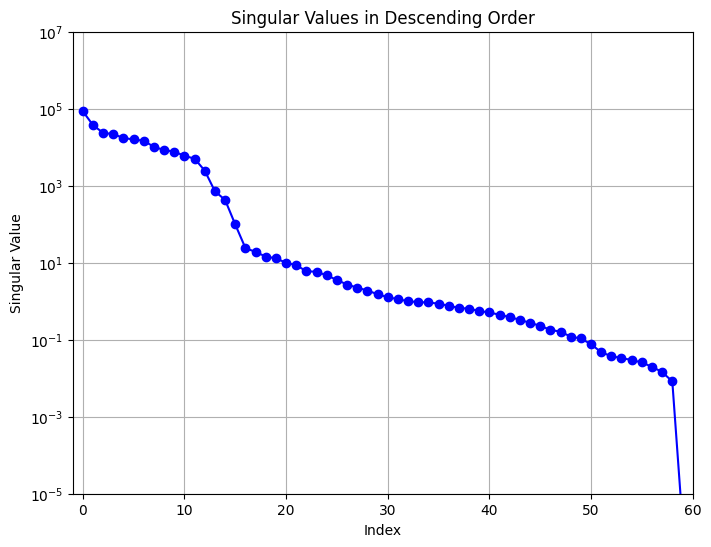

59


In [11]:
# Compute singular values of flux matrix
singular_values = np.linalg.svd(flux_matrix, compute_uv=False)
# Plot singular values in descending order
plt.figure(figsize=(8, 6))
plt.plot(singular_values, 'bo-')
plt.yscale('log')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values in Descending Order')
plt.grid(True)
plt.ylim(1e-5, 1e7)
plt.xlim(-1, 60)
plt.show()


count = count_above_threshold(singular_values, 1e-5)
print(count)

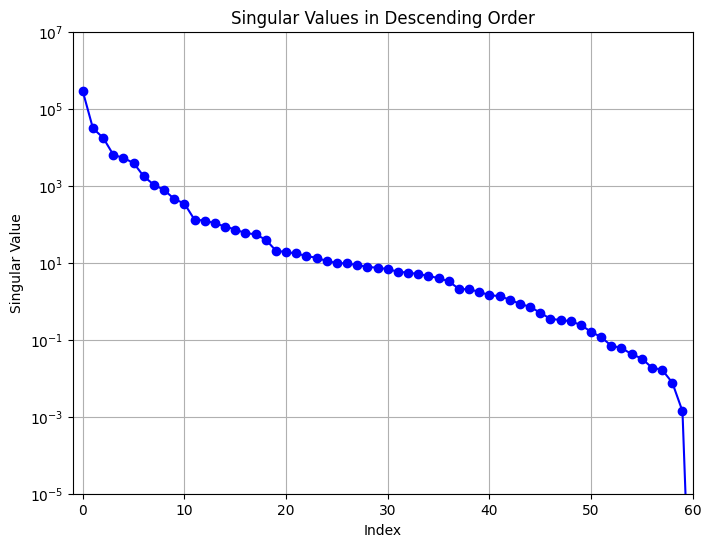

60


In [9]:
# Compute singular values of flux matrix
singular_values = np.linalg.svd(flux_matrix, compute_uv=False)
# Plot singular values in descending order
plt.figure(figsize=(8, 6))
plt.plot(singular_values, 'bo-')
plt.yscale('log')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values in Descending Order')
plt.grid(True)
plt.ylim(1e-5, 1e7)
plt.xlim(-1, 60)
plt.show()


count = count_above_threshold(singular_values, 1e-5)
print(count)
#print("Singular values of flux matrix:", singular_values)

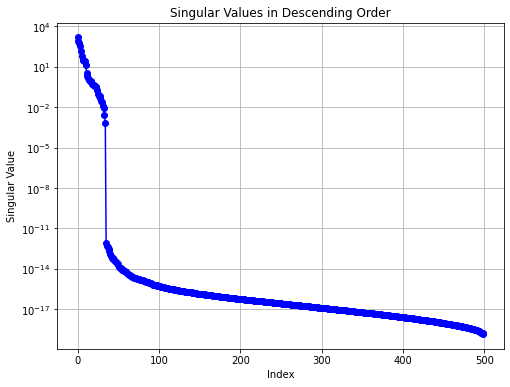

Singular values of flux matrix: [1.51855443e+03 8.25045851e+02 5.62542481e+02 3.50382752e+02
 1.38817715e+02 6.71176910e+01 3.43680500e+01 3.38266896e+01
 2.83683438e+01 2.58002240e+01 1.27067896e+01 3.53200778e+00
 2.14654011e+00 1.41874837e+00 1.01352766e+00 9.35800034e-01
 8.45305485e-01 7.08628741e-01 5.57664612e-01 4.68469258e-01
 4.17915000e-01 3.75475697e-01 3.41637266e-01 3.18713210e-01
 1.80712002e-01 9.63323217e-02 6.85661549e-02 6.56511249e-02
 4.96496136e-02 3.14916880e-02 2.46557699e-02 1.32969311e-02
 9.51871371e-03 2.50635460e-03 6.70213135e-04 7.82352171e-13
 5.14187817e-13 3.91163231e-13 3.12704504e-13 2.10395896e-13
 1.20057883e-13 8.33342349e-14 6.76489749e-14 6.29939589e-14
 4.97966400e-14 4.64599509e-14 4.12464026e-14 3.06809019e-14
 2.83788393e-14 2.21289333e-14 1.87553240e-14 1.46917255e-14
 1.25672678e-14 1.10771037e-14 9.73476601e-15 8.65241824e-15
 7.83563123e-15 7.32521911e-15 6.77981697e-15 6.05979532e-15
 5.63236526e-15 4.56917506e-15 4.43473812e-15 3.77678

In [74]:
# Compute singular values of flux matrix
singular_values = np.linalg.svd(flux_matrix, compute_uv=False)
# Plot singular values in descending order
plt.figure(figsize=(8, 6))
plt.plot(singular_values, 'bo-')
plt.yscale('log')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values in Descending Order')
plt.grid(True)
plt.show()

print("Singular values of flux matrix:", singular_values)


In [72]:


dig_entropies = [entropy_for_digits(flux_matrix[PP*i:PP*(i+1)]) for i in range(10)]
print([np.mean(dig_entropy) for dig_entropy in dig_entropies])
print([np.std(dig_entropy) for dig_entropy in dig_entropies])


[3.2802307927366994, 3.543228961314721, 3.353283714681618, 3.292735485986693, 3.4789549330711407, 3.328547812661028, 3.412569602708221, 3.400175844192729, 3.3324099871830306, 3.414516042571903]
[0.3500773376669511, 0.28667432028741346, 0.2968823779513773, 0.40007373872418767, 0.2137629441478919, 0.28296647132653147, 0.23804498032592186, 0.41344440856186243, 0.3244670812527831, 0.3591392735869244]


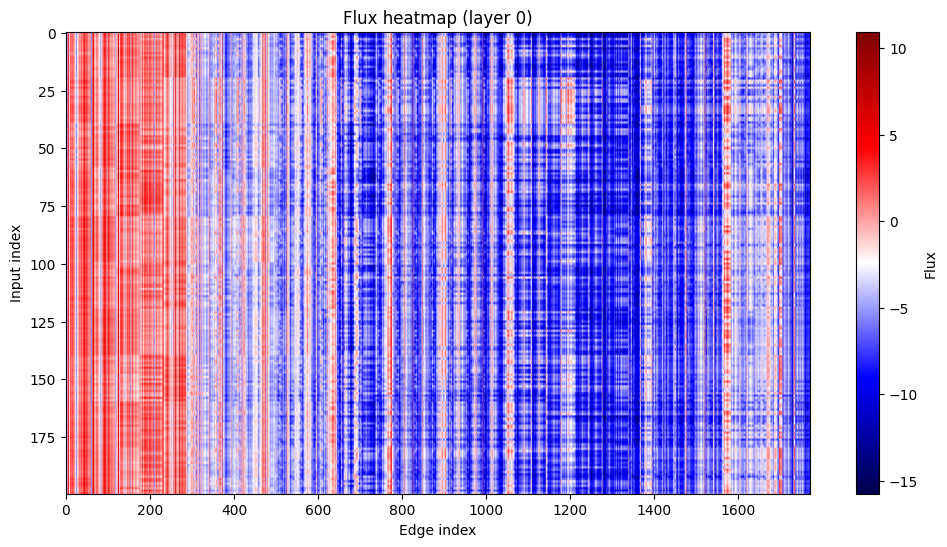

2.6190418404673412
0.6227536721582515
4.833120353471872
0.2904769964611374


In [15]:
sc_matrix = np.log(np.abs(flux_matrix))

plt.figure(figsize=(12, 6))
plt.imshow(sc_matrix, aspect='auto', cmap='seismic')
plt.colorbar(label='Flux')
plt.xlabel('Edge index')
plt.ylabel('Input index')
plt.title('Flux heatmap (layer {})'.format(layer_idx))
plt.show()

print(np.mean(entropy(flux_matrix)))
print(np.std(entropy(flux_matrix)))
print(np.mean(entropy_for_digits(flux_matrix)))
print(np.std(entropy_for_digits(flux_matrix)))

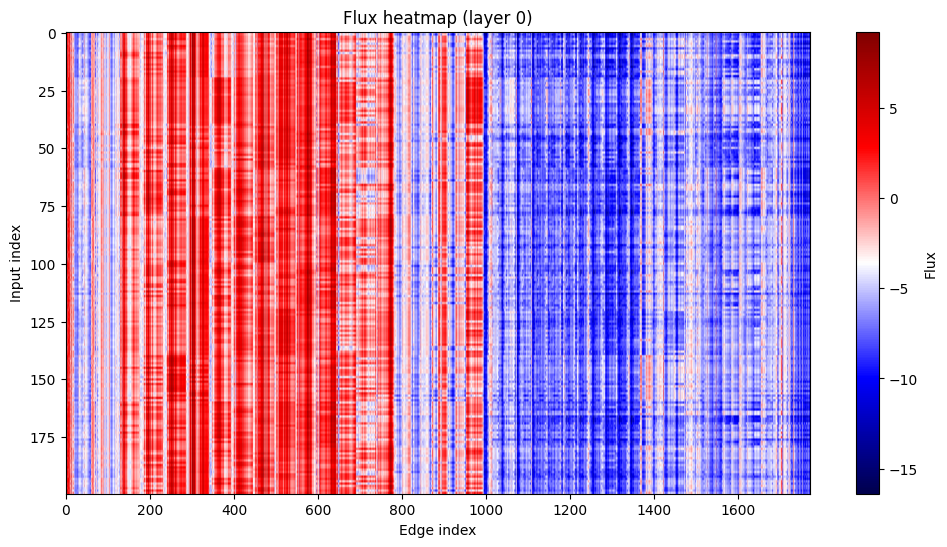

4.241061807551969
0.24642670962105928
4.878407276412238
0.2210378383643894


In [17]:
sc_matrix = np.log(np.abs(flux_matrix))

plt.figure(figsize=(12, 6))
plt.imshow(sc_matrix, aspect='auto', cmap='seismic')
plt.colorbar(label='Flux')
plt.xlabel('Edge index')
plt.ylabel('Input index')
plt.title('Flux heatmap (layer {})'.format(layer_idx))
plt.show()

print(np.mean(entropy(flux_matrix)))
print(np.std(entropy(flux_matrix)))
print(np.mean(entropy_for_digits(flux_matrix)))
print(np.std(entropy_for_digits(flux_matrix)))

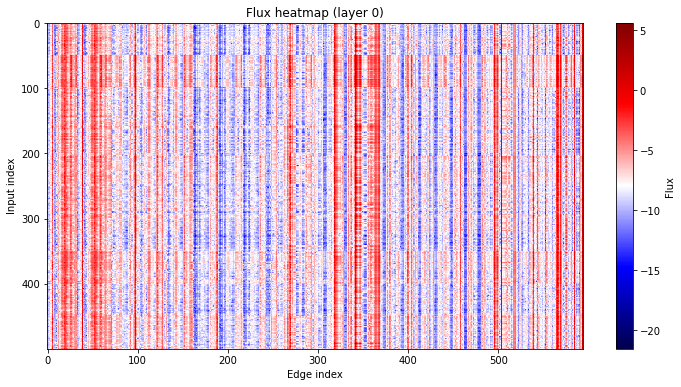

2.060324475894496
0.4592839117296144


In [60]:
sc_matrix = np.log(np.abs(flux_matrix))

plt.figure(figsize=(12, 6))
plt.imshow(sc_matrix, aspect='auto', cmap='seismic')
plt.colorbar(label='Flux')
plt.xlabel('Edge index')
plt.ylabel('Input index')
plt.title('Flux heatmap (layer {})'.format(layer_idx))
plt.show()

print(np.mean(entropy(flux_matrix)))
print(np.std(entropy(flux_matrix)))

Max abs error: 0.0007688334661687753
Mean abs error: 9.128897448733722e-06
Analytic grad (first 5): [-8.96107387e-05 -2.05854069e-05  8.64518483e-06  2.09637278e-06
  8.89186818e-07]
Numeric grad (first 5): [-9.3907118e-05 -2.2321939e-05  8.9406967e-06  2.2947788e-06
  9.8347664e-07]
Diff (first 5): [ 4.29637914e-06  1.73653258e-06 -2.95511886e-07 -1.98406048e-07
 -9.42898209e-08]


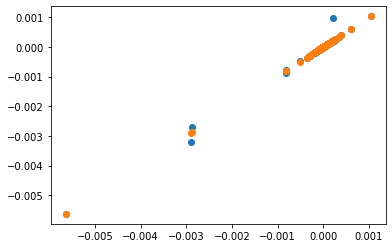

In [36]:

M = 2
inputs = next(input_data.training_data[0])
with open(input_file + str(M) + "/SavedData.pkl", 'rb') as file:
        network, input_data, accuracy_list, error_list = pickle.load(file)
        
        # Compute analytic gradient
class_idx = 0
epsilon = 1e0
verbose = True
analytic_grad = network.compute_input_gradient(inputs, class_idx)

# Compute numeric gradient using finite differences
numeric_grad = np.zeros_like(inputs, dtype=np.float32)
for k in range(len(inputs)):
    x_plus = np.array(inputs, dtype=np.float32)
    x_minus = np.array(inputs, dtype=np.float32)
    x_plus[k] += epsilon
    x_minus[k] -= epsilon
    
    # Forward pass for x_plus
    out_plus = network.compute_output(x_plus)
    # Forward pass for x_minus
    out_minus = network.compute_output(x_minus)
    
    # Use the class probability
    numeric_grad[k] = (out_plus[class_idx] - out_minus[class_idx]) / (2 * epsilon)

diff = analytic_grad - numeric_grad
if verbose:
    print("Max abs error:", np.max(np.abs(diff)))
    print("Mean abs error:", np.mean(np.abs(diff)))
    print("Analytic grad (first 5):", analytic_grad[:5])
    print("Numeric grad (first 5):", numeric_grad[:5])
    print("Diff (first 5):", diff[:5])

plt.plot(numeric_grad, analytic_grad, 'o')
plt.plot(numeric_grad, numeric_grad, 'o')
plt.show()

In [149]:
M = 2
with open(input_file + str(M) + "/SavedData.pkl", 'rb') as file:
        network, input_data, accuracy_list, error_list = pickle.load(file)


# class_idx = 4
# scale = 10.0
# inputs = np.zeros_like(next(input_data.training_data[0])) + 0.5 * scale
# prob_list = []
# for iter in range(20):
#     input_grad = network.compute_input_gradient(inputs, class_idx)   
#     inputs = inputs + 1e2 * input_grad
#     # Clip inputs above 0
#     inputs = np.clip(inputs, 0, scale)
#     prob_list.append(network.compute_output(inputs)[class_idx])

class_idx = 2
scale = 10.0
inputs = scale / 2 + np.random.uniform(-1, 1, size=next(input_data.training_data[0]).shape)
prob_list = []
step_size = 1e2
min_step = 1e-6
max_iter = 40
alpha = 0.5  # step size reduction factor
beta = 1.1   # step size increase factor

for iter in range(max_iter):
    input_grad = network.compute_input_gradient(inputs, class_idx)
    old_prob = network.compute_output(inputs)[class_idx]
    found = False
    for _ in range(10):  # Try up to 10 step size reductions
        new_inputs = np.clip(inputs + step_size * input_grad, 0, scale)
        new_prob = network.compute_output(new_inputs)[class_idx]
        if new_prob > old_prob:
            found = True
            break
        else:
            step_size *= alpha  # Reduce step size
    if not found:
        print(f"Line search failed at iter {iter}, using min step size.")
        new_inputs = np.clip(inputs + min_step * input_grad, 0, scale)
        new_prob = network.compute_output(new_inputs)[class_idx]
    else:
        step_size *= beta  # Try to increase step size next time
    inputs = new_inputs
    prob_list.append(new_prob)
    print(f"Iter {iter}: prob={new_prob:.5f}, step_size={step_size:.2e}")




Iter 0: prob=0.00064, step_size=1.10e+02
Iter 1: prob=0.00102, step_size=1.21e+02
Iter 2: prob=0.00229, step_size=1.33e+02
Iter 3: prob=0.01464, step_size=1.46e+02
Iter 4: prob=0.98866, step_size=1.61e+02
Iter 5: prob=0.99234, step_size=1.77e+02
Iter 6: prob=0.99267, step_size=1.95e+02
Iter 7: prob=0.99508, step_size=2.14e+02
Iter 8: prob=0.99645, step_size=2.36e+02
Iter 9: prob=0.99706, step_size=2.59e+02
Iter 10: prob=0.99728, step_size=2.85e+02
Iter 11: prob=0.99745, step_size=3.14e+02
Iter 12: prob=0.99760, step_size=3.45e+02
Iter 13: prob=0.99773, step_size=3.80e+02
Iter 14: prob=0.99785, step_size=4.18e+02
Iter 15: prob=0.99797, step_size=4.59e+02
Iter 16: prob=0.99808, step_size=5.05e+02
Iter 17: prob=0.99817, step_size=5.56e+02
Iter 18: prob=0.99827, step_size=6.12e+02
Iter 19: prob=0.99835, step_size=6.73e+02
Iter 20: prob=0.99843, step_size=7.40e+02
Iter 21: prob=0.99851, step_size=8.14e+02
Iter 22: prob=0.99858, step_size=8.95e+02
Iter 23: prob=0.99864, step_size=9.85e+02
It

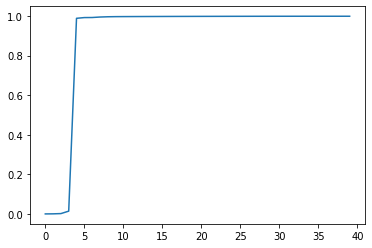

In [150]:
plt.plot(prob_list)

In [168]:
network.compute_output(next(input_data.training_data[9]))

array([1.1606537e-05, 1.8486003e-07, 1.5931206e-05, 6.2859814e-05,
       1.3068074e-02, 4.8798005e-04, 5.6213848e-05, 3.6622118e-02,
       1.0549727e-02, 9.3912530e-01], dtype=float32)

Text(0, 0.5, 'Pixel index')

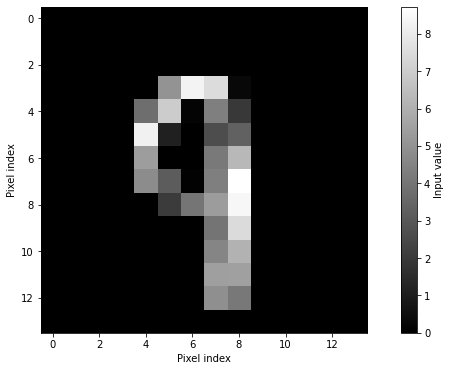

In [169]:
inputs = next(input_data.training_data[9])
input_reshape = inputs.reshape(14,14)

plt.figure(figsize=(12, 6))
plt.imshow(input_reshape, cmap='gray')
plt.colorbar(label='Input value')
plt.xlabel('Pixel index')
plt.ylabel('Pixel index')

In [16]:
M = 1
with open(input_file + str(M) + "/SavedData.pkl", 'rb') as file:
        network, input_data, accuracy_list, error_list = pickle.load(file)
        
PP = 200
output_dict = {}
for digit in range(10):
    output_dict[digit] = []
    for _ in range(PP):
        inputs = next(input_data.training_data[digit])
        ss_list, _ = network.compute_stacked_ss_on_inputs(inputs)
        ss_at_outputs = ss_list[-1][np.array(network.external_output_inds)]
        output_dict[digit].append(ss_at_outputs)




/Users/csfloyd/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


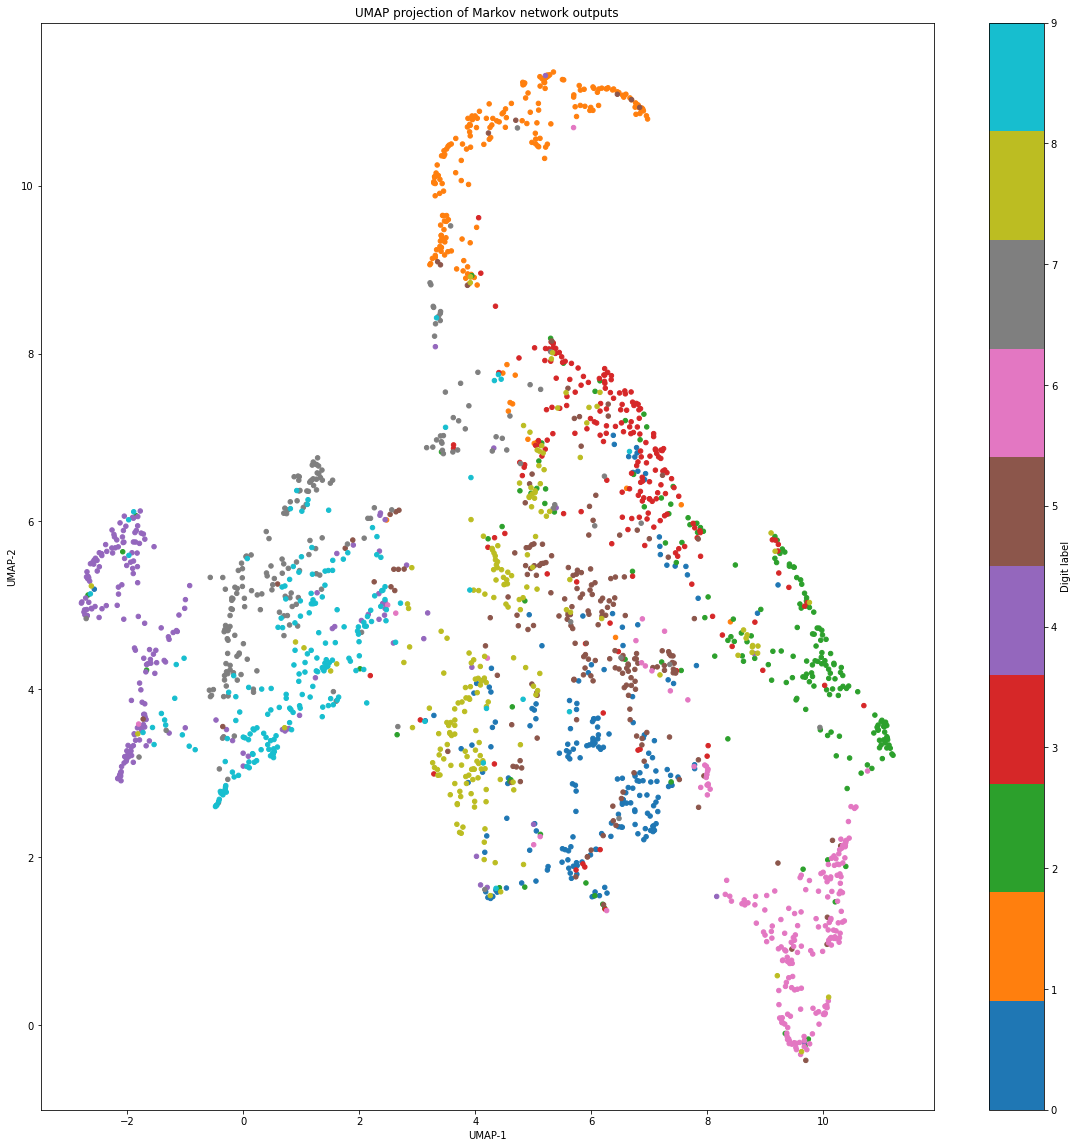

In [18]:
import numpy as np
import umap

all_vectors = []
all_labels = []

for digit in range(10):
    for vec in output_dict[digit]:
        all_vectors.append(np.array(vec))
        all_labels.append(digit)

all_vectors = np.stack(all_vectors)  # shape: (10*PP, vector_dim)
all_labels = np.array(all_labels)    # shape: (10*PP,)

reducer = umap.UMAP(random_state=20)
embedding = reducer.fit_transform(all_vectors)  # shape: (10*PP, 2)

plt.figure(figsize=(20, 20))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=all_labels, cmap='tab10', s=20)
plt.colorbar(scatter, ticks=range(10), label='Digit label')
plt.title('UMAP projection of Markov network outputs')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

In [ ]:
input_file = "/Users/csfloyd/Library/CloudStorage/Dropbox/Projects/MarkovComputation/Dirs/"
input_file = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/Dirs/"

with open(input_file + "SavedData.pkl", 'rb') as file:
    weight_matrix, input_data, accuracy_list, input_inds, output_inds = pickle.load(file)

# file = input_file + "SavedData.pkl"
# print(file)
# weight_matrix, input_data, accuracy_list = pickle.load(file)

In [ ]:
################################################
################  Plot results #################
################################################



### plot the accuracy
plt.figure(figsize=(8, 5))
plt.plot(accuracy_list)
plt.xlabel("Training iterations")
plt.ylabel("Accuracy on data")
plt.ylim(0,1.1)
#plt.xlim(0,n_training_iters / training_stride)
plt.show()




In [ ]:

###################################################
################  Get predictions #################
###################################################

n_classes = len(input_data.training_data)
print(evaluate_accuracy(weight_matrix, input_inds, input_data, output_inds, n_classes, 500))
predictions_per_class = evaluate_accuracy_per_class(weight_matrix, input_inds, input_data, output_inds, 500, n_classes)

plt.figure(figsize=(10, 2))
plt.imshow(predictions_per_class, cmap='gray')  # Show in grayscale
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()


In [ ]:
print("a" + "b")